In [2]:
import sys
import numpy as np
import xarray as xr
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.colors import Normalize
from numba import jit
import seaborn as sns
from utilities import *
from calc_TEM import *
%matplotlib inline

# sns.set_style('ticks')
colors=colordefs()
# norm = MidpointNormalize(midpoint=0)
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

gw = xr.open_dataset('../pp_data/gw.nc',decode_times=False)['gw'].squeeze()

In [3]:
H  = 7.0e3
a = 6.37e6
g  = 9.8
om = 7.292e-5  
R = 287.05
Cp = 1.0035e3

In [4]:
def return_day_array(time):
    days_in_month = [31,28,31,30,31,30,31,31,30,31,30]
    temp = 0
    day_of_year = [temp]
    for i in days_in_month:
        temp += i
        day_of_year.append(temp)
    day_of_year = np.array(day_of_year)
    
    target = time.shape[0]
    dummy = 0
    yearp1 = day_of_year+365
    days = np.concatenate([day_of_year,yearp1])
    i = 0
    while dummy != target:
        yearp1 = yearp1+365
        days = np.concatenate([days,yearp1])
        dummy = days.shape[0]
        i+=1
        if i>100:
            break
    return days

In [5]:
def differentiate_DA(DataArray,time):
    dDAdt = DataArray.copy(deep=True)
    dDAdt[:] = 0.0
    dDAdt[:] = np.gradient(DataArray,time,axis=0,edge_order=2)
    return dDAdt

In [6]:
def differtiate_DA_lat(DataArray):
    a = 6.37e6
    phi = np.deg2rad(DataArray.lat).values
    dDAdy = DataArray.copy(deep=True)
    dDAdy[:] = 0.0
    dDAdy[:] = (1/a)*np.gradient(DataArray,(phi[1]-phi[0]),axis=-1,edge_order=2)
    return dDAdy

In [7]:
def differentiate_DA_z(DataArray,P0=100000):
    z = 7e3*np.log(P0/(100*DataArray.lev))
    dDAdz = DataArray.copy(deep=True)
    dDAdz[:] = 0.0
    dDAdz[:] = np.gradient(DataArray,z,axis=1,edge_order=2)
    return dDAdz

In [12]:
ctrzon = xr.open_dataset('../pp_data/bwma1850.f09.y30.los_chocoyos.qboW.ensoN.SO2.cam.h0.0030-0064.zonmean.nc',decode_times=False)
# ctrzon.time.values = (ctrzon.time.values-ctrzon.time.values[0])/365
# ctrzon.time.values
ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.
# ctrzon = ctrzon.sel(time=slice(5,100))
# ctrzon.time.values = np.arange(ctrzon.time.shape[0])/12.
# ctrzon.time.values = (ctrzon.time.values-ctrzon.time.values[0])

pre = xr.open_dataset('../pp_data/bwma1850.f09.test1.cam.h0.y30_pre.zonmean.nc',decode_times=False)
pre.time.values = np.arange(pre.time.shape[0])/12.
pre.time.values = pre.time.values-np.ceil(pre.time.values.max())

climzon = xr.open_dataset('../pp_data/bwma1850.f09.test1.cam.h0.year.zonmean.nc',decode_times=False)
climT = climzon['T']

# AOD_data = xr.open_dataset('ECHAM_LCY/choc001_2015-2018_AOD_AS_CS.nc',decode_times=False).squeeze()
AOD_data = xr.open_dataset('../pp_data/ECHAM_LCY/choc005_2015-2018_AOD_AS_CS_zm_verts.nc',decode_times=True).squeeze().isel(time=slice(24,100))
replacement_time = (np.arange(AOD_data.time.shape[0])/12.)
AOD_data.time.values=replacement_time

In [22]:
U = xr.concat([pre['U'],ctrzon['U']],dim='time')

In [14]:
T = xr.concat([pre['T'],ctrzon['T']],dim='time')

In [20]:
Uc = get_clim_with_same_dims_v2(U,climzon['U'])
Uc.time.values = U.time.values
Ua = U-Uc.values

In [38]:
Tc = get_clim_with_same_dims_v2(T,climzon['T'])
Tc.time.values = T.time.values
Ta = T-Tc.values

In [23]:
AOD = ctrzon['AODVISdn'].sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))
AOD_glob = ctrzon['AODVISdn'].reduce(np.average,dim='lat',weights=gw)

In [24]:
EAOD = AOD_data['TAU_MODE_AS']+AOD_data['TAU_MODE_CS']
# EAOD.squeeze().plot.contourf(x='time')

In [25]:
weigts = np.cos(np.deg2rad(AOD_data.lat))

In [26]:
weigts.sel(lat=[-2,2],method='nearest')

<xarray.DataArray 'lat' (lat: 2)>
array([0.99970349, 0.99970349])
Coordinates:
    lon      float64 0.0
  * lat      (lat) float64 -1.395 1.395

In [27]:
EAOD_trop = EAOD.sel(lat=[-2,2],method='nearest').reduce(np.average,dim='lat',weights=weigts.sel(lat=[-2,2],method='nearest'))


In [30]:
EAOD_glob = EAOD.reduce(np.average,dim='lat',weights=weigts)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


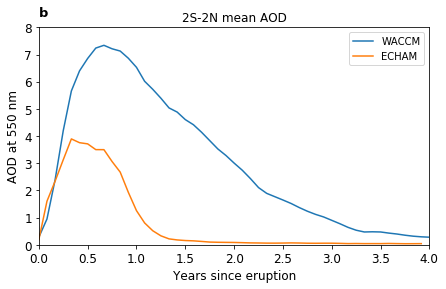

In [28]:
plt.figure(figsize=(7,4))
AOD.plot.line(label='WACCM')
EAOD_trop.plot.line(label='ECHAM')
plt.legend()
plt.xlim([0,4])
plt.ylim([0,8])
plt.yticks(np.arange(9))
plt.xlabel('Years since eruption',fontsize=12)
plt.ylabel('AOD at 550 nm',fontsize=12)
plt.title('2S-2N mean AOD',fontsize=12)
plt.gca().text(-0.0,1.05,'b',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('ECHAM_WACCM_QBO_AOD.png',dpi=300,bbox_inches='tight')

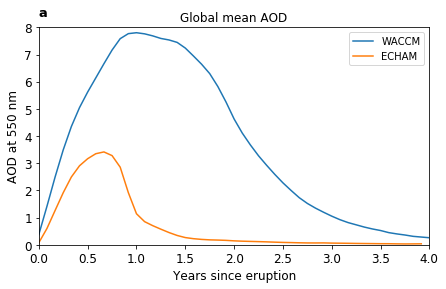

In [31]:
plt.figure(figsize=(7,4))
AOD_glob.plot.line(label='WACCM')
EAOD_glob.plot.line(label='ECHAM')
plt.legend()
plt.xlim([0,4])
plt.ylim([0,8])
plt.yticks(np.arange(9))
plt.xlabel('Years since eruption',fontsize=12)
plt.ylabel('AOD at 550 nm',fontsize=12)
plt.title('Global mean AOD',fontsize=12)
plt.gca().text(-0.0,1.05,'a',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('ECHAM_WACCM_glob_AOD.png',dpi=300,bbox_inches='tight')

In [32]:
days = return_day_array(T.time)

In [41]:
dTadt = differentiate_DA(Ta,days)

In [42]:
dUdz = differentiate_DA_z(U)*1000

In [34]:
test=sns.diverging_palette(255,15,sep=1,s=99,l=40,as_cmap=True)

In [36]:
def qbo_plot_with_cs(wind,tanom,pmin=0.8,pmax=200,tmin=0,tmax=10,cf_levels=np.linspace(-50,50,21),
             cs_levels=np.linspace(-40,40,9),figsize=(14,3),cmap=test,title='dummy',
             xlabel='Years since eruption',clblabel='Zonal wind [m/s]'):
    
    plt.figure(figsize=figsize)
    CF = wind.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))).sel(lev=slice(pmin,pmax)).plot.contourf(x='time',levels=cf_levels,cmap=cmap,add_colorbar=False,extend='both')
    CS = tanom.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2))).sel(lev=slice(pmin,pmax)).plot.contour(x='time',levels=cs_levels,colors='black',add_colorbar=False)
#     CS.monochrome = True
    for line, lvl in zip(CS.collections, CS.levels):
        line.set_color('xkcd:grey')
        if lvl < 0:
            line.set_linestyle('--')
        elif lvl == 0:
            line.set_linestyle(':')
            line.set_color('k')
        else:
            # Optional; this is the default.
            line.set_linestyle('-')
    plt.clabel(CS,fmt='%1.0f',inline=False)
    plt.yscale('log')
    plt.gca().invert_yaxis()
    clb=plt.colorbar(CF)
    clb.set_label(clblabel,fontsize=12)
    plt.xlim([tmin,tmax])
    plt.ylim([pmax,1])
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel('Pressure level [hPa]',fontsize=14)
    plt.title(title,fontsize=14)

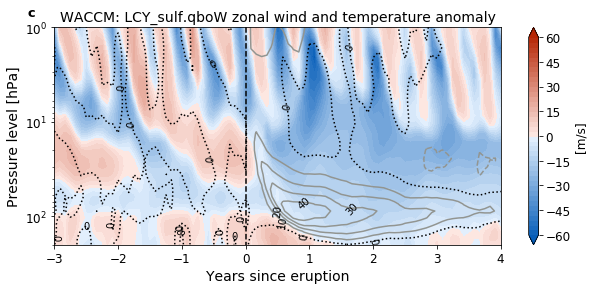

In [39]:
qbo_plot_with_cs(U,Ta,cf_levels=np.linspace(-60,60,41),tmin=-3,tmax=4,cs_levels=np.linspace(-40,40,9),xlabel='Years since eruption',clblabel='[m/s]',title='WACCM: LCY_sulf.qboW zonal wind and temperature anomaly',figsize=(10,4))
plt.vlines(0,1000,0.01,linestyle='--')
plt.gca().text(-0.06,1.05,'c',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('WACCM_QBO_U_compWE.png',dpi=300,bbox_inches='tight')

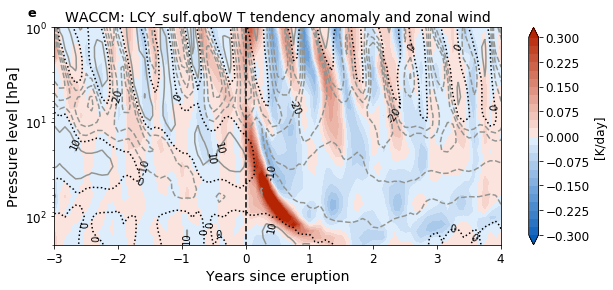

In [43]:
qbo_plot_with_cs(dTadt,U,cf_levels=np.linspace(-0.3,0.3,25),tmin=-3,tmax=4,cs_levels=np.linspace(-30,30,7),xlabel='Years since eruption',clblabel='[K/day]',title='WACCM: LCY_sulf.qboW T tendency anomaly and zonal wind',figsize=(10,4))
plt.vlines(0,1000,0.01,linestyle='--')
plt.gca().text(-0.06,1.05,'e',transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
plt.savefig('WACCM_QBO_dTdt_compWE.png',dpi=300,bbox_inches='tight')

In [53]:
! gm montage -geometry +2+2 -tile 2x3 ECHAM_WACCM_glob_AOD.png ECHAM_WACCM_QBO_AOD.png WACCM_QBO_U_compWE.png ECHAM_QBO_U_compWE.png WACCM_QBO_dTdt_compWE.png ECHAM_QBO_dTdt_compWE.png WACCM_ECHAM_COMP.png